# Data - How Institutions of Higher Education Can Mine The Key Ingredient of  A Successful Analytics Program

The development of data analytics programs that foster robust decision support systems have become a key component of strategic initiatives for institutions of higher-education. However, college and university leadership teams remain unsure of how to effectively incorporate analytics into the institution's operations.

The object of this project is to explore the power of a predictive system based on the notion that at the end of each semester we can diagnose the chances of a student graduating in 4 years based on all available information up to that point. 

One main objective is to identify an information saturation point upon which actionable intervention is implemented. The hypothesis is that there exists a local maxima saturation point which provides the most appropriate intervention point.

# Tools

In [457]:
# General
from __future__ import print_function, division
import sys

# Database
import cx_Oracle
from sqlalchemy import create_engine
from getpass import getpass

# Tools
import pandas as pd
import seaborn as sns
import random
import string
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
import time
#import pandas_profiling

pd.options.display.max_columns = None

# Analytics
#import pymc3 as pm
from scipy.stats import beta

#IMBALANCED DATA
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#SciKitLearn Models
from sklearn.linear_model import LogisticRegression, ElasticNetCV, SGDClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier #(wait for scikit release 18.0)
from sklearn.neighbors import KNeighborsClassifier

#XgBoost Model ###################################################################################
# import os
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
##################################################################################################

#MODEL SELECTION, #EVALUATION METRICS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

# Academic Data: Performance & Demographics

#### Grades Data
First we obtain the students grades along with a few variables. The goal is to aggregate the grade records to a semester summary.

In [458]:
username = input('Enter username: ')

password = getpass(prompt='Enter password: ')

Enter username: japitz
Enter password: ········


In [459]:
service_name = 'iraarch'
host = 'ira-oradb01.its.csulb.edu'
port = '1521'
grades_query = 'grd.sql'
dem_query = 'dae.sql'

def db_query(username, password, service_name, host, port, query):

    dsn = cx_Oracle.makedsn(host, port, service_name=service_name)

    cstr = 'oracle://{user}:{password}@{dsn}'.format(
        user=username,
        password=password,
        dsn=dsn
    )

    engine =  create_engine(
        cstr,
        convert_unicode=False,
        pool_recycle=10,
        pool_size=50,
    )

    with open(query, 'r') as f:
        data=f.read()#.replace('\n', '')
        
    return (data, engine)

In [460]:
grades, engine = db_query(username, password, service_name, host, port, grades_query)
grd = pd.read_sql(grades, engine)

demo, engine = db_query(username, password, service_name, host, port, dem_query)
dem = pd.read_sql(demo, engine)


print(grd.shape)
print(dem.shape)

(1018245, 39)
(15802, 24)


In [461]:
grd.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018245 entries, 0 to 1018244
Data columns (total 39 columns):
cohort                     1018245 non-null object
emplid                     1018245 non-null object
term_code                  1018245 non-null object
class_term                 1018245 non-null object
session_code               1018245 non-null object
eot_acad_career            1018245 non-null object
eot_program_cd             1018245 non-null object
eot_program                1018245 non-null object
eot_college_cd             1018059 non-null object
eot_college                1018059 non-null object
eot_department_cd          1018059 non-null object
eot_department             1018059 non-null object
eot_acad_plan_cd           1018245 non-null object
eot_acad_plan              1018245 non-null object
class_college_code         1018245 non-null object
class_college              1018245 non-null object
class_dept_code            1018245 non-null object
class_dept          

In [462]:
dem.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15802 entries, 0 to 15801
Data columns (total 24 columns):
emplid                   15802 non-null object
dem_cohort               15802 non-null object
dem_diff_indx            11480 non-null float64
dae_emplid               15802 non-null object
gender                   15802 non-null object
ethnicity                15802 non-null object
first_generation         15802 non-null object
dep_family_size          15802 non-null object
minority                 15802 non-null object
applicant_family_size    15802 non-null object
applicant_income         15802 non-null object
pelltot_emplid           8975 non-null object
pell_eligibility         8975 non-null object
esa_emplid               15801 non-null object
act_comp                 5396 non-null float64
act_read                 5397 non-null float64
act_math                 5398 non-null float64
act_eng                  5394 non-null float64
act_sci                  5397 non-null float64

In [463]:
#Change 'UNKNOWN' to more unique string to avoid having columns with same name after one-hot-encode

dem['first_generation'] = dem['first_generation'].apply(lambda x: 'First Generation Unknown' if x == 'UNKNOWN' else x)
dem['ethnicity'] = dem['ethnicity'].apply(lambda x: 'ETHNICITY UNKNOWN' if x == 'UNKNOWN' else x)

##### Create Training and Test/Validation Sets of Students at this stage to avoid leakeage 

In [464]:
students = pd.DataFrame(grd['emplid'].unique(), columns=['emplid'])

print('there are {} students'.format(students.shape[0]))

there are 26779 students


##### Create the Grades Trainning and Validation Student Set

In [465]:
students_train, students_dev = train_test_split(students, test_size=0.10, random_state=42)

students_train = pd.DataFrame(students_train)

students_dev = pd.DataFrame(students_dev)

In [466]:
students_train.columns = ['EMPLID']
students_dev.columns = ['EMPLID']

In [467]:
grd[grd['emplid']=='011155428'].sort_values(by=['term_code'])

,cohort,emplid,term_code,class_term,session_code,eot_acad_career,eot_program_cd,eot_program,eot_college_cd,eot_college,eot_department_cd,eot_department,eot_acad_plan_cd,eot_acad_plan,class_college_code,class_college,class_dept_code,class_dept,class_prefix,class_prefix_longdesc,class_catalog_nbr,class_section,class_descr,bcmp,bcmp_units_taken,online_course,units_taken,grading_basis,official_grade,earned_credit,units_attempted,grade_points,status_cd,ge_flag,division,gpa_flag,class_instruction_mode,class_instructor_emplid,home_zip_cd
600692,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,WGSS,Women's Gender Sexuality Stds,WGSS,Women's Gender Sexuality Stds,101,06,Women & Their Bodies,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,001420573,92683
565248,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PSY,Psychology,PSY,Psychology,100,01,General Psychology,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,000003300,92683
498657,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PHIL,Philosophy,PHIL,Philosophy,170,04,Critical Reasoning,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,006822970,92683
622480,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,HIST,History,HIST,History,173,15,Recent United States History,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,005157605,92683
622497,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CHHS,Health and Human Services,KIN,Kinesiology,KIN,Kinesiology,109A,02,Fitness Walking,0,0,Not_Online,1.0,GCR,A,Y,Y,4.0,E,Non_GE,Lower-Division,Include_in_GPA,P,000041481,92683
600721,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,ENGL,English,ENGL,English,100,34,Composition II,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,000040389,92683
598928,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,06,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009460618,92683
581276,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,01,General Organic & Biochemistry,1,5,Not_Online,5.0,GRD,C,Y,Y,10.0,E,GE,Lower-Division,Include_in_GPA,P,000033863,92683
531066,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,MATH,Mathematics,MATH,Mathematics,109,11,Modeling With Algebra,1,3,Not_Online,3.0,GCR,A,Y,Y,12.0,E,GE,Lower-Division,Include_in_GPA,P,008331555,92683
457447,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,13,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009416548,92683


# Preprocessing: One-Hot-Encode Letter Grades

In [468]:
grd.columns = map(str.upper, grd.columns)

In [469]:
grd = pd.concat([grd,pd.get_dummies(grd['OFFICIAL_GRADE'], drop_first=True)], axis=1)

grd.shape

(1018245, 52)

##### Create Variables to Calculate GPA

In [470]:
grd['GRADE_POINTS_IN_GPA'] = grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_IN_GPA'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_FOR_CREDIT'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

#######################################################################################################################

grd['BCMP_GRADE_POINTS_IN_GPA'] = grd['BCMP'] * grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_IN_GPA'] = grd['BCMP_UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_FOR_CREDIT'] = grd['BCMP'] * grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

In [471]:
grd['SUMMER'] = (grd['TERM_CODE'].apply(lambda x: str(x)[-1]) == '3')* 1 * grd['UNITS_FOR_CREDIT']

grd['WINTER'] = (grd['TERM_CODE'].apply(lambda x: str(x)[-1]) == '1')* 1 * grd['UNITS_FOR_CREDIT']

##### Reduce the dataframe to variables of current interest

In [472]:
grd = grd.sort_values(by=['EMPLID','TERM_CODE']).copy()[['COHORT', 
                 'EMPLID', 
                 'TERM_CODE',
                 'EOT_ACAD_PLAN_CD',
                 'GRADE_POINTS_IN_GPA',
                 'UNITS_TAKEN',
                 'UNITS_IN_GPA',
                 'UNITS_FOR_CREDIT',
                 'BCMP',
                 'BCMP_GRADE_POINTS_IN_GPA',
                 'BCMP_UNITS_TAKEN',
                 'BCMP_UNITS_IN_GPA',
                 'BCMP_UNITS_FOR_CREDIT',
                 'A', 
                 'AU', 
                 'B',
                 'C', 
                 'CR', 
                 'D', 
                 'F', 
                 'I', 
                 'NC', 
                 'RP', 
                 'W', 
                 'WE', 
                 'WU',
                 'SUMMER',
                 'WINTER']]

##### Aggregate and Reduce from Course Dimension to Term Dimension: Create a cummulative sum of Grade Points and GPA Units:

In [473]:
aggregations = { 'GRADE_POINTS_IN_GPA':'sum',
                 'UNITS_TAKEN':'sum',
                 'UNITS_IN_GPA':'sum',
                 'UNITS_FOR_CREDIT':'sum',
                 'BCMP':'sum',
                 'BCMP_GRADE_POINTS_IN_GPA':'sum',
                 'BCMP_UNITS_TAKEN':'sum',
                 'BCMP_UNITS_IN_GPA':'sum',
                 'BCMP_UNITS_FOR_CREDIT':'sum',
                 'A':'sum', 
                 'AU':'sum', 
                 'B':'sum',
                 'C':'sum', 
                 'CR':'sum', 
                 'D':'sum', 
                 'F':'sum', 
                 'I':'sum', 
                 'NC':'sum', 
                 'RP':'sum', 
                 'W':'sum', 
                 'WE':'sum', 
                 'WU':'sum',
               'SUMMER':'sum',
               'WINTER':'sum'}

grouped_agg = grd.groupby(['COHORT','EMPLID','TERM_CODE','EOT_ACAD_PLAN_CD']).agg(aggregations).reset_index()

In [474]:
grouped_agg.head(6)

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0
5,2094,000095652,2112,DANCBA01U1,42.0,15.0,15.0,15.0,0,0.0,0,0.0,0.0,0,0,4,1,0,0,0,0,0,0,0,0,0,0.0,0.0


In [475]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER
991854,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
931931,2094,000095652,2094,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
932384,2094,000095652,2094,DANCBA01U1,2.0,2.0,2.0,2.0,0,0.0,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0
935539,2094,000095652,2094,DANCBA01U1,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
942012,2094,000095652,2094,DANCBA01U1,4.0,1.0,1.0,1.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0


In [476]:
grouped_agg.head(10)

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0
5,2094,000095652,2112,DANCBA01U1,42.0,15.0,15.0,15.0,0,0.0,0,0.0,0.0,0,0,4,1,0,0,0,0,0,0,0,0,0,0.0,0.0
6,2094,000206204,2094,L/STBA04U1,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
7,2094,000206204,2102,L/STBA04U1,28.0,10.0,7.0,7.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0
8,2094,000206204,2104,L/STBA04U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
9,2094,000206204,2112,L/STBA04U1,36.0,9.0,9.0,9.0,2,12.0,3,3.0,3.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0


In [477]:
grouped_cumsum = grd[['EMPLID',
                      'TERM_CODE',
                      'GRADE_POINTS_IN_GPA',
                      'UNITS_TAKEN',
                      'UNITS_IN_GPA',
                      'UNITS_FOR_CREDIT',
                      'BCMP',
                      'BCMP_GRADE_POINTS_IN_GPA',
                      'BCMP_UNITS_TAKEN',
                      'BCMP_UNITS_IN_GPA',
                      'BCMP_UNITS_FOR_CREDIT',
                      'SUMMER',
                      'WINTER']].groupby(['EMPLID',
                                          'TERM_CODE']).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

In [478]:
grouped_cumsum.head(12)

,CUM_EMPLID,CUM_TERM_CODE,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER
0,000095652,2092,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0.0,0.0
1,000095652,2094,59.0,21.0,21.0,21.0,0,0.0,0,0.0,0.0,0.0,0.0
2,000095652,2102,122.0,39.0,39.0,39.0,0,0.0,0,0.0,0.0,0.0,0.0
3,000095652,2104,158.0,53.0,53.0,53.0,0,0.0,0,0.0,0.0,0.0,0.0
4,000095652,2111,170.0,56.0,56.0,56.0,0,0.0,0,0.0,0.0,0.0,3.0
5,000095652,2112,212.0,71.0,71.0,71.0,0,0.0,0,0.0,0.0,0.0,3.0
6,000106897,2104,33.0,12.0,12.0,12.0,0,0.0,0,0.0,0.0,0.0,0.0
7,000106897,2112,66.0,24.0,24.0,24.0,0,0.0,0,0.0,0.0,0.0,0.0
8,000106897,2114,99.0,36.0,36.0,36.0,0,0.0,0,0.0,0.0,0.0,0.0
9,000106897,2122,134.0,50.0,49.0,50.0,0,0.0,0,0.0,0.0,0.0,0.0


In [479]:
grouped_cumsum.rename(columns={'CUM_EMPLID':'EMPLID','CUM_TERM_CODE':'TERM_CODE'},inplace=True)


In [480]:
grd = pd.merge(grouped_agg, grouped_cumsum, on=['EMPLID','TERM_CODE'], how='left')

#grd.drop(['CUM_EMPLID','CUM_TERM_CODE'],axis=1,inplace=True)

In [481]:
print(grouped_agg.shape)
print(grouped_cumsum.shape)
print(grd.shape)

(214005, 28)
(213997, 13)
(214005, 39)


In [482]:
grd[['EMPLID','COHORT','TERM_CODE','EOT_ACAD_PLAN_CD','UNITS_TAKEN','CUM_UNITS_TAKEN']].head(11)

,EMPLID,COHORT,TERM_CODE,EOT_ACAD_PLAN_CD,UNITS_TAKEN,CUM_UNITS_TAKEN
0,000095652,2094,2092,UCESOT00OU,3.0,3.0
1,000095652,2094,2094,DANCBA01U1,18.0,21.0
2,000095652,2094,2102,DANCBA01U1,18.0,39.0
3,000095652,2094,2104,DANCBA01U1,14.0,53.0
4,000095652,2094,2111,DANCBA01U1,3.0,56.0
5,000095652,2094,2112,DANCBA01U1,15.0,71.0
6,000206204,2094,2094,L/STBA04U1,6.0,6.0
7,000206204,2094,2102,L/STBA04U1,10.0,16.0
8,000206204,2094,2104,L/STBA04U1,3.0,19.0
9,000206204,2094,2112,L/STBA04U1,9.0,28.0


#### Create Term and Cummulative GPA

In [483]:
grd['TERM_GPA'] = grd['GRADE_POINTS_IN_GPA'] / grd['UNITS_IN_GPA']

grd['CUM_GPA'] = grd['CUM_GRADE_POINTS_IN_GPA'] / grd['CUM_UNITS_IN_GPA']

grd['BCMP_TERM_GPA'] = grd['BCMP_GRADE_POINTS_IN_GPA'] / grd['BCMP_UNITS_IN_GPA']

grd['BCMP_CUM_GPA'] = grd['CUM_BCMP_GRADE_POINTS_IN_GPA'] / grd['CUM_BCMP_UNITS_IN_GPA']

##### Check for NaN values since division by 0 is possible:

In [484]:
grd.isnull().sum()

COHORT                               0
EMPLID                               0
TERM_CODE                            0
EOT_ACAD_PLAN_CD                     0
GRADE_POINTS_IN_GPA                  0
UNITS_TAKEN                          0
UNITS_IN_GPA                         0
UNITS_FOR_CREDIT                     0
BCMP                                 0
BCMP_GRADE_POINTS_IN_GPA             0
BCMP_UNITS_TAKEN                     0
BCMP_UNITS_IN_GPA                    0
BCMP_UNITS_FOR_CREDIT                0
A                                    0
AU                                   0
B                                    0
C                                    0
CR                                   0
D                                    0
F                                    0
I                                    0
NC                                   0
RP                                   0
W                                    0
WE                                   0
WU                       

###### Need to deal with NaN values - use imputation

##### impute missing Term and Cum GPA

In this instance it is reasonable to set the Term GPA and CumGPA to zero since NaNs result from Units in GPA and Cum Units in GPA being zero. This means either the student had no Units in GPA for a given term or the Cum Units in GPA was zero since the student failed to pass units in the initial term

In [485]:
grd.fillna(0, inplace=True)

##### Example of students with CumGPA = 0 

In [486]:
grd[grd['CUM_GPA'] == 0].head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
160,2094,003397379,2094,I/STBA01U1,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,0.0,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,2094,003397379,2102,I/STBA01U1,0.0,6.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,2,0,0.0,0.0,0.0,12.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,2094,003761574,2052,HISTBA01U1,0.0,7.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,2,0,0,0.0,0.0,0.0,7.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,2094,003761574,2094,HISTBA01U1,0.0,13.0,13.0,13.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,3,0.0,0.0,0.0,20.0,13.0,13.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347,2094,004147609,2094,PSY_PR00U1,0.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.0,0.0,0.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [487]:
emplid = '011375323'

grd[grd['EMPLID'] == emplid]

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
212608,2124,011375323,2124,NRSGBS02U1,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0,0.0,0.0,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Typically students with CumGPA = 0 fail or withdraw

In [488]:
grd[grd['EMPLID'] == emplid].iloc[0]

COHORT                                2124
EMPLID                           011375323
TERM_CODE                             2124
EOT_ACAD_PLAN_CD                NRSGBS02U1
GRADE_POINTS_IN_GPA                      0
UNITS_TAKEN                              9
UNITS_IN_GPA                             0
UNITS_FOR_CREDIT                         0
BCMP                                     0
BCMP_GRADE_POINTS_IN_GPA                 0
BCMP_UNITS_TAKEN                         0
BCMP_UNITS_IN_GPA                        0
BCMP_UNITS_FOR_CREDIT                    0
A                                        0
AU                                       0
B                                        0
C                                        0
CR                                       0
D                                        0
F                                        0
I                                        0
NC                                       0
RP                                       0
W          

# The Load Index

$L_s = \dfrac{\sum_{i=1}^{k_s} u_i}{U_s}$

$u_i: units\ \ earned \ \ by \ \ taking \ \ class \ \ i.$

$k_s: number \ \ of \ \ classes \ \ taken \ \ in \ \ semester \ \ s.$

$U_s: number \ \ of \ \ units \ \ prescribed \ \ to \ \ be \ \ earned \ \ by \ \ semester \ \ s.$

$The \ \ pattern \ \  of \ \ the \ \ difference \ \  d \ \ 0,7,8,9,10,17,18,19,20,... \ \ $

$Pattern \ \ when \ \ d \ \ mod \ \ 10 \ \ is \ \ 0$    $$N = 2\dfrac{d}{10} + 1 = \dfrac{d}{5} + 1$$

Pattern when d mod 10 is 8    $$N = 2\left(\dfrac{d - 8}{10} + 1\right) = \dfrac{d + 2}{5}$$

In [489]:
grd['TERM_DIFF'] = pd.to_numeric(grd['TERM_CODE']) - pd.to_numeric(grd['COHORT'])
# SEMESTER INDICATOR #
grd['N'] = grd['TERM_DIFF'].apply(lambda x: int(x/5+1) if x%10 == 0 else int((x + 2)/5) )

grd['PRESCRIBED_UNITS'] = grd['N'] * 15

In [490]:
grd['N'].head()

0    0
1    1
2    2
3    3
4    3
Name: N, dtype: int64

In [491]:
grd.head(6)

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0.0,0.0,3.000000,3.000000,0.0,0.0,-2,0,0
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0,59.0,21.0,21.0,21.0,0,0.0,0,0.0,0.0,0.0,0.0,2.777778,2.809524,0.0,0.0,0,1,15
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,122.0,39.0,39.0,39.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,3.128205,0.0,0.0,8,2,30
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0,158.0,53.0,53.0,53.0,0,0.0,0,0.0,0.0,0.0,0.0,2.571429,2.981132,0.0,0.0,10,3,45
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,170.0,56.0,56.0,56.0,0,0.0,0,0.0,0.0,0.0,3.0,4.000000,3.035714,0.0,0.0,17,3,45
5,2094,000095652,2112,DANCBA01U1,42.0,15.0,15.0,15.0,0,0.0,0,0.0,0.0,0,0,4,1,0,0,0,0,0,0,0,0,0,0.0,0.0,212.0,71.0,71.0,71.0,0,0.0,0,0.0,0.0,0.0,3.0,2.800000,2.985915,0.0,0.0,18,4,60


In [492]:
grd[['EMPLID','COHORT','TERM_CODE','N']].head(19)

,EMPLID,COHORT,TERM_CODE,N
0,000095652,2094,2092,0
1,000095652,2094,2094,1
2,000095652,2094,2102,2
3,000095652,2094,2104,3
4,000095652,2094,2111,3
5,000095652,2094,2112,4
6,000206204,2094,2094,1
7,000206204,2094,2102,2
8,000206204,2094,2104,3
9,000206204,2094,2112,4


In [493]:
grd['LOAD_INDEX'] = grd['CUM_UNITS_FOR_CREDIT'] / grd['PRESCRIBED_UNITS']

grd['COMPLETION_RATE'] = grd['UNITS_FOR_CREDIT'] / grd['UNITS_TAKEN']

## Create The Exclusive Load Index 

In [494]:
grd['UNITS_FOR_CREDIT_EXCLUDE'] = (grd['TERM_DIFF'] >= 0) * grd['UNITS_FOR_CREDIT']

grouped_cumsum = grd[['EMPLID',
                      'TERM_CODE',
                      'UNITS_FOR_CREDIT_EXCLUDE']].groupby(['EMPLID',
                                                            'TERM_CODE']).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

In [495]:
grouped_cumsum.head()

,CUM_EMPLID,CUM_TERM_CODE,CUM_UNITS_FOR_CREDIT_EXCLUDE
0,000095652,2092,0.0
1,000095652,2094,18.0
2,000095652,2102,36.0
3,000095652,2104,50.0
4,000095652,2111,53.0


In [496]:
grouped_cumsum.rename(columns={'CUM_EMPLID':'EMPLID','CUM_TERM_CODE':'TERM_CODE'},inplace=True)
grouped_cumsum.head()

,EMPLID,TERM_CODE,CUM_UNITS_FOR_CREDIT_EXCLUDE
0,000095652,2092,0.0
1,000095652,2094,18.0
2,000095652,2102,36.0
3,000095652,2104,50.0
4,000095652,2111,53.0


In [497]:
grd = pd.merge(grd, grouped_cumsum, on=['EMPLID','TERM_CODE'], how='left') 

grd['N_EXCLUDE'] = grd['TERM_DIFF'].apply(lambda x: 0 if x < 0 else(int(x/5+1) if int(repr(x)[-1]) == 0 else int((x + 2)/5) ))

grd['PRESCRIBED_UNITS_EXCLUDE'] = grd['N_EXCLUDE'] * 15

grd['LOAD_INDEX_EXCLUDE'] = grd['CUM_UNITS_FOR_CREDIT_EXCLUDE'] / grd['PRESCRIBED_UNITS_EXCLUDE']

In [498]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,CUM_UNITS_FOR_CREDIT_EXCLUDE,N_EXCLUDE,PRESCRIBED_UNITS_EXCLUDE,LOAD_INDEX_EXCLUDE
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0.0,0.0,3.000000,3.000000,0.0,0.0,-2,0,0,inf,1.0,0.0,0.0,0,0,NaN
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0,59.0,21.0,21.0,21.0,0,0.0,0,0.0,0.0,0.0,0.0,2.777778,2.809524,0.0,0.0,0,1,15,1.400000,1.0,18.0,18.0,1,15,1.200000
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,122.0,39.0,39.0,39.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,3.128205,0.0,0.0,8,2,30,1.300000,1.0,18.0,36.0,2,30,1.200000
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0,158.0,53.0,53.0,53.0,0,0.0,0,0.0,0.0,0.0,0.0,2.571429,2.981132,0.0,0.0,10,3,45,1.177778,1.0,14.0,50.0,3,45,1.111111
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,170.0,56.0,56.0,56.0,0,0.0,0,0.0,0.0,0.0,3.0,4.000000,3.035714,0.0,0.0,17,3,45,1.244444,1.0,3.0,53.0,3,45,1.177778


## Create the Only Prior Load Index Indicator

In [499]:
grd['LOAD_INDEX_ONLY']=grd['LOAD_INDEX']-grd['LOAD_INDEX_EXCLUDE']

grouped_diff = grd[['EMPLID', 'LOAD_INDEX_ONLY']].groupby(['EMPLID']).transform(max).reset_index()

grd = grd.drop(columns='LOAD_INDEX_ONLY')

In [500]:
grd.shape

(214005, 53)

In [501]:
grouped_diff.shape

(214005, 2)

In [502]:
grd = pd.concat([grd,grouped_diff],axis=1)

grd[['LOAD_INDEX_ONLY','N']].head()

,LOAD_INDEX_ONLY,N
0,0.2,0
1,0.2,1
2,0.2,2
3,0.2,3
4,0.2,3


In [503]:
grd.head(14)

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,CUM_UNITS_FOR_CREDIT_EXCLUDE,N_EXCLUDE,PRESCRIBED_UNITS_EXCLUDE,LOAD_INDEX_EXCLUDE,index,LOAD_INDEX_ONLY
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0.0,0.0,3.000000,3.000000,0.0,0.000000,-2,0,0,inf,1.0,0.0,0.0,0,0,NaN,0,0.2
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0,59.0,21.0,21.0,21.0,0,0.0,0,0.0,0.0,0.0,0.0,2.777778,2.809524,0.0,0.000000,0,1,15,1.400000,1.0,18.0,18.0,1,15,1.200000,1,0.2
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,122.0,39.0,39.0,39.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,3.128205,0.0,0.000000,8,2,30,1.300000,1.0,18.0,36.0,2,30,1.200000,2,0.2
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0,158.0,53.0,53.0,53.0,0,0.0,0,0.0,0.0,0.0,0.0,2.571429,2.981132,0.0,0.000000,10,3,45,1.177778,1.0,14.0,50.0,3,45,1.111111,3,0.2
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,170.0,56.0,56.0,56.0,0,0.0,0,0.0,0.0,0.0,3.0,4.000000,3.035714,0.0,0.000000,17,3,45,1.244444,1.0,3.0,53.0,3,45,1.177778,4,0.2
5,2094,000095652,2112,DANCBA01U1,42.0,15.0,15.0,15.0,0,0.0,0,0.0,0.0,0,0,4,1,0,0,0,0,0,0,0,0,0,0.0,0.0,212.0,71.0,71.0,71.0,0,0.0,0,0.0,0.0,0.0,3.0,2.800000,2.985915,0.0,0.000000,18,4,60,1.183333,1.0,15.0,68.0,4,60,1.133333,5,0.2
6,2094,000206204,2094,L/STBA04U1,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,4.000000,4.000000,0.0,0.000000,0,1,15,0.400000,1.0,6.0,6.0,1,15,0.400000,6,0.0
7,2094,000206204,2102,L/STBA04U1,28.0,10.0,7.0,7.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,52.0,16.0,13.0,13.0,0,0.0,0,0.0,0.0,0.0,0.0,4.000000,4.000000,0.0,0.000000,8,2,30,0.433333,0.7,7.0,13.0,2,30,0.433333,7,0.0
8,2094,000206204,2104,L/STBA04U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,64.0,19.0,16.0,16.0,0,0.0,0,0.0,0.0,0.0,0.0,4.000000,4.000000,0.0,0.000000,10,3,45,0.355556,1.0,3.0,16.0,3,45,0.355556,8,0.0
9,2094,000206204,2112,L/STBA04U1,36.0,9.0,9.0,9.0,2,12.0,3,3.0,3.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,100.0,28.0,25.0,25.0,2,12.0,3,3.0,3.0,0.0,0.0,4.000000,4.000000,4.0,4.000000,18,4,60,0.416667,1.0,9.0,25.0,4,60,0.416667,9,0.0


## Create DFW Variables

In [504]:
grd['DFW'] = grd['D'] + grd['F'] + grd['I'] + grd['NC'] + grd['W'] + grd['WE'] + grd['WU']

grd['DFW_RATE'] = grd['DFW']/grd['UNITS_TAKEN']

## Select Varaibles

In [505]:
grd.drop(labels=['GRADE_POINTS_IN_GPA','UNITS_IN_GPA','BCMP_GRADE_POINTS_IN_GPA','BCMP_UNITS_IN_GPA',
                 'CUM_GRADE_POINTS_IN_GPA','CUM_UNITS_IN_GPA', 'CUM_BCMP_GRADE_POINTS_IN_GPA', 'TERM_DIFF',
                 'CUM_UNITS_FOR_CREDIT_EXCLUDE','N_EXCLUDE', 'PRESCRIBED_UNITS_EXCLUDE', 
                 'index'],axis=1, inplace=True)

## Exclude Rows Before $T_0$

In [506]:
grd = grd[grd['COHORT'] <= grd['TERM_CODE']]

In [507]:
grd.head(13)

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,UNITS_TAKEN,UNITS_FOR_CREDIT,BCMP,BCMP_UNITS_TAKEN,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_UNITS_TAKEN,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,N,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW,DFW_RATE
1,2094,000095652,2094,DANCBA01U1,18.0,18.0,0,0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0,21.0,21.0,0,0,0.0,0.0,0.0,0.0,2.777778,2.809524,0.0,0.000000,1,15,1.400000,1.0,18.0,1.200000,0.2,1,0.055556
2,2094,000095652,2102,DANCBA01U1,18.0,18.0,0,0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,39.0,39.0,0,0,0.0,0.0,0.0,0.0,3.500000,3.128205,0.0,0.000000,2,30,1.300000,1.0,18.0,1.200000,0.2,0,0.000000
3,2094,000095652,2104,DANCBA01U1,14.0,14.0,0,0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0,53.0,53.0,0,0,0.0,0.0,0.0,0.0,2.571429,2.981132,0.0,0.000000,3,45,1.177778,1.0,14.0,1.111111,0.2,1,0.071429
4,2094,000095652,2111,DANCBA01U1,3.0,3.0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,56.0,56.0,0,0,0.0,0.0,0.0,3.0,4.000000,3.035714,0.0,0.000000,3,45,1.244444,1.0,3.0,1.177778,0.2,0,0.000000
5,2094,000095652,2112,DANCBA01U1,15.0,15.0,0,0,0.0,0,0,4,1,0,0,0,0,0,0,0,0,0,0.0,0.0,71.0,71.0,0,0,0.0,0.0,0.0,3.0,2.800000,2.985915,0.0,0.000000,4,60,1.183333,1.0,15.0,1.133333,0.2,0,0.000000
6,2094,000206204,2094,L/STBA04U1,6.0,6.0,0,0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,6.0,6.0,0,0,0.0,0.0,0.0,0.0,4.000000,4.000000,0.0,0.000000,1,15,0.400000,1.0,6.0,0.400000,0.0,0,0.000000
7,2094,000206204,2102,L/STBA04U1,10.0,7.0,0,0,0.0,2,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,16.0,13.0,0,0,0.0,0.0,0.0,0.0,4.000000,4.000000,0.0,0.000000,2,30,0.433333,0.7,7.0,0.433333,0.0,1,0.100000
8,2094,000206204,2104,L/STBA04U1,3.0,3.0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,19.0,16.0,0,0,0.0,0.0,0.0,0.0,4.000000,4.000000,0.0,0.000000,3,45,0.355556,1.0,3.0,0.355556,0.0,0,0.000000
9,2094,000206204,2112,L/STBA04U1,9.0,9.0,2,3,3.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,28.0,25.0,2,3,3.0,3.0,0.0,0.0,4.000000,4.000000,4.0,4.000000,4,60,0.416667,1.0,9.0,0.416667,0.0,0,0.000000
10,2094,000206204,2114,L/STBA04U1,9.0,9.0,2,3,3.0,1,0,2,0,0,0,0,0,0,0,0,0,0,0.0,0.0,37.0,34.0,4,6,6.0,6.0,0.0,0.0,3.333333,3.823529,3.0,3.500000,5,75,0.453333,1.0,9.0,0.453333,0.0,0,0.000000


##### The Completion Rate calculation generated a few NaNs

Setting these NaNs to zero is appropriate since they result from dividing by zero (no units taken)

In [508]:
grd.fillna(0, inplace=True)

## Demographic Data

In [509]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP'],
      dtype='object')

### One-Hot-Encode Demographics

In [510]:
dem = pd.concat([dem,
                pd.get_dummies(dem['GENDER'], drop_first=True, prefix='GENDR'),
                pd.get_dummies(dem['ETHNICITY'], drop_first=False),
                pd.get_dummies(dem['FIRST_GENERATION'], drop_first=False),
                pd.get_dummies(dem['DEP_FAMILY_SIZE'], drop_first=False, prefix='DEP_FAM'),
                pd.get_dummies(dem['MINORITY'], drop_first=False, prefix='URM'), 
                pd.get_dummies(dem['APPLICANT_FAMILY_SIZE'], drop_first=False, prefix='APP_FAM'),
                pd.get_dummies(dem['APPLICANT_INCOME'], drop_first=False, prefix='INCM'),
                pd.get_dummies(dem['PELL_ELIGIBILITY'], drop_first=False, prefix='PELL')], axis=1)

In [511]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY'

In [512]:
dem.drop(labels=['GENDER', 'ETHNICITY', 'FIRST_GENERATION',
       'DEP_FAMILY_SIZE', 'MINORITY', 'APPLICANT_FAMILY_SIZE',
       'APPLICANT_INCOME', 'PELL_ELIGIBILITY'], axis=1, inplace=True)

### Create Time to Graduation Response Variables

In [513]:
dem['DEM_N'] = dem['DEM_DIFF_INDX'].apply(lambda x: x if (x >= 0) == False 
                             else int(x/5+1) if (x%10 == 0 or x%10 == 7) 
                             else int((x + 2)/5) )

dem['YRS_TO_GRAD'] = dem['DEM_N'] * 0.5

In [514]:
dem[['DEM_DIFF_INDX','YRS_TO_GRAD']].head(12)

,DEM_DIFF_INDX,YRS_TO_GRAD
0,38.0,4.0
1,49.0,5.0
2,40.0,4.5
3,48.0,5.0
4,NaN,NaN
5,NaN,NaN
6,40.0,4.5
7,38.0,4.0
8,58.0,6.0
9,40.0,4.5


In [515]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'PELLTOT_EMPLID',
       'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI',
       'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
   

In [516]:
dem = pd.concat([dem,pd.get_dummies(dem['YRS_TO_GRAD'], drop_first=False, prefix='GRAD_IN')], axis=1)

In [517]:
dem.drop(labels=['DEM_DIFF_INDX','DEM_N','DAE_EMPLID','PELLTOT_EMPLID','ESA_EMPLID',
                 'YRS_TO_GRAD'], axis=1, inplace=True)

In [518]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_

In [519]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_

### Join the Demographic Data with the CSULB Academic Performance Data

In [520]:
dem = dem.rename(columns={'DEM_COHORT':'COHORT'})

In [521]:
dem.columns

Index(['EMPLID', 'COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_$12,

In [522]:
supreme = pd.merge(dem, grd, on=['EMPLID','COHORT'], how='left')

In [523]:
# pandas_profiling.ProfileReport(supreme)

In [524]:
#pandas_profiling.ProfileReport(supreme).get_rejected_variables()

In [525]:
# supreme.drop(labels=[ 'DFW',
#                       'AP',
#                       'BCMP_UNITS_FOR_CREDIT',
#                       'BCMP_UNITS_TAKEN',
#                       'CUM_BCMP_UNITS_FOR_CREDIT',
#                       'CUM_BCMP_UNITS_IN_GPA',
#                       'CUM_BCMP_UNITS_TAKEN',
#                       'CUM_UNITS_FOR_CREDIT',
#                       'INCM_NO RESPONSE',
#                       'UNITS_FOR_CREDIT',
#                       'URM_UNKNOWN',
#                       'URM_VISA NON U.S.'], axis=1, inplace=True)

In [526]:
pd.options.display.max_seq_items = supreme.columns.shape[0]

supreme.columns

Index(['EMPLID', 'COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_$12,

### ACT, SAT and HS GPA Scores Preprocessing

Students may have ACT or SAT or both scores. The idea is to create a feature that would capture test performance in a general sense. The approach use here is to create three features that capture performance in Math, Reading and Composite performance. To this end we scale and center both ACT and SAT test scores in math, reading and composite and, in the event a student has taken both,choose the maximum normalized score.

##### Need to impute missing values of ACT and SAT scores:

Before this preprocessing step is undertaken it is necessary to split the student data into trainning and development sets in order to avoid "leakeage" from trainning into development since the imputing calculations and methods use the entire dataset.

In [527]:
supreme['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: N, dtype: float64

In [528]:
supreme_train = pd.merge(students_train, supreme, on='EMPLID', how='inner')
print(supreme_train.shape)

supreme_dev = pd.merge(students_dev, supreme, on='EMPLID', how='inner')
print(supreme_dev.shape)

(131374, 125)
(14474, 125)


In [529]:
supreme_dev['GPA_HS']=supreme_dev['GPA_HS']/100
supreme_train['GPA_HS']=supreme_train['GPA_HS']/100

In [530]:
supreme_train.isnull().sum().head(55)

EMPLID                                        0
COHORT                                        0
ACT_COMP                                  86239
ACT_READ                                  86233
ACT_MATH                                  86223
ACT_ENG                                   86260
ACT_SCI                                   86233
SAT_READ                                   6251
SAT_MATH                                   6251
SAT_COMP                                   6251
GPA_HS                                      509
AP                                       131374
GENDR_M                                       0
AFRICAN AMERICAN                              0
ASIAN AMERICAN                                0
CAUCASIAN                                     0
ETHNICITY UNKNOWN                             0
LATINO/LATINA                                 0
NATIVE AMERICAN                               0
PACIFIC ISLANDER                              0
TWO OR MORE RACES, INCLUDING MINORITY   

In [531]:
supreme_train.iloc[:,44:57].columns

Index(['URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA'],
      dtype='object')

In [532]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP', 'GPA_HS']].head()

,ACT_COMP,ACT_READ,ACT_MATH,ACT_ENG,ACT_SCI,SAT_READ,SAT_MATH,SAT_COMP,GPA_HS
0,NaN,NaN,NaN,NaN,NaN,520.0,410.0,930.0,3.6
1,NaN,NaN,NaN,NaN,NaN,520.0,410.0,930.0,3.6
2,NaN,NaN,NaN,NaN,NaN,520.0,410.0,930.0,3.6
3,NaN,NaN,NaN,NaN,NaN,520.0,410.0,930.0,3.6
4,NaN,NaN,NaN,NaN,NaN,520.0,410.0,930.0,3.6


In [533]:
supreme_train['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: N, dtype: float64

##### Scale the scores and choose the max

In [534]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [535]:
supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [536]:
print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].mean()
)

print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].std()
)

ACT_COMP    3.470950e-16
ACT_READ    2.396494e-16
ACT_MATH   -6.804643e-16
ACT_ENG     1.002385e-15
ACT_SCI     3.447063e-16
SAT_READ    7.563373e-16
SAT_MATH   -2.638338e-15
SAT_COMP   -2.295178e-15
dtype: float64
ACT_COMP    1.000011
ACT_READ    1.000011
ACT_MATH    1.000011
ACT_ENG     1.000011
ACT_SCI     1.000011
SAT_READ    1.000004
SAT_MATH    1.000004
SAT_COMP    1.000004
dtype: float64


In [537]:
supreme_train['T_COMP'] = supreme_train[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_train['T_READ'] = supreme_train[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_train['T_MATH'] = supreme_train[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [538]:
supreme_dev['T_COMP'] = supreme_dev[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_READ'] = supreme_dev[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_MATH'] = supreme_dev[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [539]:
supreme_train[['T_COMP','T_READ','T_MATH']].isnull().sum()

T_COMP    1395
T_READ    1395
T_MATH    1395
dtype: int64

##### For now impute values by using the mean

In [540]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [541]:
test_scores = supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

In [542]:
test_scores = supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

##### Drop unecessary features

In [543]:
supreme_train['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: N, dtype: float64

In [544]:
supreme_train.columns[30:50]

Index(['DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25',
       'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7',
       'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3'],
      dtype='object')

In [545]:
supreme_train.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

supreme_dev.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

##### The AP feature is null - impute with a constant for now

In [546]:
supreme_train['AP'] = 0

supreme_dev['AP'] = 0

In [547]:
supreme_train.isnull().sum().head(55)

EMPLID                                   0
COHORT                                   0
GPA_HS                                   0
AP                                       0
GENDR_M                                  0
AFRICAN AMERICAN                         0
ASIAN AMERICAN                           0
CAUCASIAN                                0
ETHNICITY UNKNOWN                        0
LATINO/LATINA                            0
NATIVE AMERICAN                          0
PACIFIC ISLANDER                         0
TWO OR MORE RACES, INCLUDING MINORITY    0
TWO OR MORE RACES, NON-MINORITIES        0
VISA NON U.S.                            0
CONTINUING GENERATION STUDENT            0
FIRST GENERATION STUDENT                 0
FIRST GENERATION UNKNOWN                 0
DEP_FAM_1                                0
DEP_FAM_10                               0
DEP_FAM_11                               0
DEP_FAM_12                               0
DEP_FAM_13                               0
DEP_FAM_14 

### Create the Major Plan Change Index

##### Academic plans are 10 characters in length

In [548]:
supreme_train['EOT_ACAD_PLAN_CD'].head()

0    NDUGOT00U1
1    NDUGOT00U1
2    HCA_BS01U1
3    HCA_BS01U1
4    HCA_BS01U1
Name: EOT_ACAD_PLAN_CD, dtype: object

In [549]:
supreme_train['EOT_ACAD_PLAN_CD'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: str(x))
supreme_dev['EOT_ACAD_PLAN_CD'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: str(x))

In [550]:
supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: len(x)).describe()

count    131374.000000
mean          9.999947
std           0.019313
min           3.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: EOT_ACAD_PLAN_CD, dtype: float64

##### The first 4 characters representthe department/subject. The 5th and 6th character encode the plan type and allows to separate pre-majors from majors. A change from pre-major to major in the same department/subject is not considered a major change.

In [551]:
print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6]).head()
)

print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4]).head()
)

0    OT
1    OT
2    BS
3    BS
4    BS
Name: EOT_ACAD_PLAN_CD, dtype: object
0    NDUG
1    NDUG
2    HCA_
3    HCA_
4    HCA_
Name: EOT_ACAD_PLAN_CD, dtype: object


##### Create codes

In [552]:
supreme_train['SUBJECT'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_train['PLAN_TYPE'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [553]:
supreme_dev['SUBJECT'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_dev['PLAN_TYPE'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [554]:
supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].head()

,EMPLID,SUBJECT,PLAN_TYPE
0,011131924,NDUG,OT
1,011131924,NDUG,OT
2,011131924,HCA_,BS
3,011131924,HCA_,BS
4,011131924,HCA_,BS


##### Create Major Change indicator

In [555]:
supreme_train['MAJOR_CHANGE_INDICATOR'] = ( supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)

In [556]:
supreme_dev['MAJOR_CHANGE_INDICATOR'] = ( supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)

In [557]:
#supreme_train[['UNITS_TAKEN','CUM_UNITS_TAKEN']][supreme_train['EMPLID'] == '010705940']#[supreme_train['EMPLID'] == '007884004']
supreme_train[supreme_train['EMPLID'] == '010705940']#[supreme_train['EMPLID'] == '007884004']

,EMPLID,COHORT,GPA_HS,AP,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,ETHNICITY UNKNOWN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_11,DEP_FAM_12,DEP_FAM_13,DEP_FAM_14,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,URM_UNKNOWN,URM_VISA NON U.S.,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_4,APP_FAM_5,APP_FAM_6,APP_FAM_7,APP_FAM_8,APP_FAM_9,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$24,000 TO $35,999","INCM_$36,000 TO $47,999","INCM_$48,000 TO $59,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_CANNOT ESTIMATE,INCM_LESS THEN $6000,INCM_NO RESPONSE,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0,GRAD_IN_6.5,GRAD_IN_7.0,GRAD_IN_7.5,GRAD_IN_8.0,GRAD_IN_8.5,GRAD_IN_9.0,TERM_CODE,EOT_ACAD_PLAN_CD,UNITS_TAKEN,UNITS_FOR_CREDIT,BCMP,BCMP_UNITS_TAKEN,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_UNITS_TAKEN,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,N,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW,DFW_RATE,T_COMP,T_READ,T_MATH,SUBJECT,PLAN_TYPE,MAJOR_CHANGE_INDICATOR
119195,010705940,2124,3.36,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2124,BIOLPR07U1,16.0,16.0,1.0,4.0,4.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,18.0,2.0,5.0,0.0,5.0,2.0,0.0,2.181818,2.181818,0.0,0.000000,1.0,15.0,1.200000,1.0,16.0,1.066667,0.133333,0.0,0.0,-1.640854,-1.332223,-1.588,BIOL,PR,0
119196,010705940,2124,3.36,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2132,SW__PR00U1,12.0,12.0,1.0,4.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,30.0,3.0,9.0,0.0,9.0,2.0,0.0,2.285714,2.222222,0.0,0.000000,2.0,30.0,1.000000,1.0,12.0,0.933333,0.133333,0.0,0.0,-1.640854,-1.332223,-1.588,SW__,PR,1
119197,010705940,2124,3.36,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2134,SW__PR00U1,12.0,12.0,1.0,3.0,3.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,42.0,4.0,12.0,3.0,12.0,2.0,0.0,2.500000,2.333333,2.0,2.000000,3.0,45.0,0.933333,1.0,12.0,0.888889,0.133333,0.0,0.0,-1.640854,-1.332223,-1.588,SW__,PR,0
119198,010705940,2124,3.36,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2142,SOC_PR00U1,12.0,12.0,1.0,3.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,54.0,5.0,15.0,6.0,15.0,2.0,0.0,2.750000,2.452381,3.0,2.500000,4.0,60.0,0.900000,1.0,12.0,0.866667,0.133333,0.0,0.0,-1.640854,-1.332223,-1.588,SOC_,PR,1
119199,010705940,2124,3.36,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2144,SOC_BA01U1,16.0,16.0,2.0,3.0,3.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,70.0,7.0,18.0,9.0,18.0,2.0,0.0,3.062500,2.620690,2.0,2.333333,5.0,75.0,0.933333,1.0,16.0,0.906667,0.133333,0.0,0.0,-1.640854,-1.332223,-1.588,SOC_,BA,0
119200,010705940,2124,3.36,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2152,SOC_BA01U1,13.0,13.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,83.0,7.0,18.0,9.0,18.0,2.0,0.0,2.84615

##### Create a cumulative Major Change Counter

In [558]:
grouped_cumsum = supreme_train[['EMPLID','MAJOR_CHANGE_INDICATOR']].groupby(['EMPLID']).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_train = pd.concat([supreme_train,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_train.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

In [559]:
supreme_train[supreme_train['EMPLID'] == '007884004']#[supreme_train['EMPLID'] == '007884004']

,EMPLID,COHORT,GPA_HS,AP,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,ETHNICITY UNKNOWN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_11,DEP_FAM_12,DEP_FAM_13,DEP_FAM_14,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,URM_UNKNOWN,URM_VISA NON U.S.,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_4,APP_FAM_5,APP_FAM_6,APP_FAM_7,APP_FAM_8,APP_FAM_9,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$24,000 TO $35,999","INCM_$36,000 TO $47,999","INCM_$48,000 TO $59,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_CANNOT ESTIMATE,INCM_LESS THEN $6000,INCM_NO RESPONSE,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0,GRAD_IN_6.5,GRAD_IN_7.0,GRAD_IN_7.5,GRAD_IN_8.0,GRAD_IN_8.5,GRAD_IN_9.0,TERM_CODE,EOT_ACAD_PLAN_CD,UNITS_TAKEN,UNITS_FOR_CREDIT,BCMP,BCMP_UNITS_TAKEN,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_UNITS_TAKEN,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,SEMESTER_INDEX,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW,DFW_RATE,T_COMP,T_READ,T_MATH,SUBJECT,PLAN_TYPE,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT


In [560]:
grouped_cumsum = supreme_dev[['EMPLID','MAJOR_CHANGE_INDICATOR']].groupby(['EMPLID']).cumsum().reset_index()


grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_dev = pd.concat([supreme_dev,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_dev.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

In [561]:
supreme_dev[supreme_dev['EMPLID'] == '007884004']

,EMPLID,COHORT,GPA_HS,AP,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,ETHNICITY UNKNOWN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_11,DEP_FAM_12,DEP_FAM_13,DEP_FAM_14,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,URM_UNKNOWN,URM_VISA NON U.S.,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_4,APP_FAM_5,APP_FAM_6,APP_FAM_7,APP_FAM_8,APP_FAM_9,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$24,000 TO $35,999","INCM_$36,000 TO $47,999","INCM_$48,000 TO $59,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_CANNOT ESTIMATE,INCM_LESS THEN $6000,INCM_NO RESPONSE,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0,GRAD_IN_6.5,GRAD_IN_7.0,GRAD_IN_7.5,GRAD_IN_8.0,GRAD_IN_8.5,GRAD_IN_9.0,TERM_CODE,EOT_ACAD_PLAN_CD,UNITS_TAKEN,UNITS_FOR_CREDIT,BCMP,BCMP_UNITS_TAKEN,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_UNITS_TAKEN,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,SEMESTER_INDEX,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW,DFW_RATE,T_COMP,T_READ,T_MATH,SUBJECT,PLAN_TYPE,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT
9148,007884004,2094,2.83,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2094,NDUGOT00U1,12.0,9.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,9.0,1.0,3.0,3.0,3.0,0.0,0.0,2.666667,2.666667,2.0,2.000000,1.0,15.0,0.600000,0.750000,9.0,0.600000,0.0,1.0,0.083333,-0.258092,-0.819001,0.304713,NDUG,OT,0,0
9149,007884004,2094,2.83,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2102,NDUGOT00U1,15.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,27.0,21.0,1.0,3.0,3.0,3.0,0.0,0.0,2.333333,2.500000,0.0,2.000000,2.0,30.0,0.700000,0.800000,12.0,0.700000,0.0,1.0,0.066667,-0.258092,-0.819001,0.304713,NDUG,OT,0,0
9150,007884004,2094,2.83,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2104,NRSGPR00U1,13.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,34.0,1.0,3.0,3.0,3.0,0.0,0.0,1.769231,2.193548,0.0,2.000000,3.0,45.0,0.755556,1.000000,13.0,0.755556,0.0,2.0,0.153846,-0.258092,-0.819001,0.304713,NRSG,PR,1,1
9151,007884004,2094,2.83,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2112,NRSGPR00U1,12.0,7.0,3.0,5.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.0,41.0,4.0,8.0,3.0,3.0,0.0,0.0,2.285714,2.210526,0.0,2.000000,4.0,60.0,0.683333,0.583333,7.0,0.683333,0.0,1.0,0.083333,-0.258092,-0.819001,0.304713,NRSG,PR,0,1
9152,007884004,2094,2.83,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2114,NRSGPR00U1,12.0,12.0,3.0,5.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,53.0,7.0,13.0,8.0,8.0,0.0,0.0,1.333333,2.000000,0.0,0.750000,5.0,75.0,0.706667,1.000000,12.0,0.706667,0.0,2.0,0.166667,-0.258092,-0.819001,0.304713,NRSG,PR,0,1
9153,007884004,2094,2.83,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2122,NRSGPR00U1,9.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

##### Rearrange features

In [562]:
supreme_train.columns

Index(['EMPLID', 'COHORT', 'GPA_HS', 'AP', 'GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN', 'LATINO/LATINA',
       'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$24,000 TO $35,999',
       'INCM_$36,000 TO $47,999', 'INCM_$48,000 TO $59,99

In [563]:
id_var = ['COHORT', 'EMPLID']

perf_var = ['TERM_CODE', 'SEMESTER_INDEX', 'EOT_ACAD_PLAN_CD', 'MAJOR_CHANGE_INDICATOR','MAJOR_CHANGE_CNT',
            'UNITS_TAKEN','BCMP', 'A', 'AU', 'B' ,'C','CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER', 
            'CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 'TERM_GPA','CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA',
            'COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY','DFW_RATE','T_COMP', 'T_READ','T_MATH']

dem_var = ['GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN','ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 
           'NATIVE AMERICAN','PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
           'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.','CONTINUING GENERATION STUDENT', 
           'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN','DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
           'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6','DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 
           'DEP_FAM_NA', 'URM_MINORITY','URM_NON-MINORITY', 'APP_FAM_1',
           'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA','INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
           'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL', 
           'PELL_TRADITIONAL']

resp_var = ['GRAD_IN_2.5','GRAD_IN_3.0', 'GRAD_IN_3.5', 'GRAD_IN_4.0', 'GRAD_IN_4.5','GRAD_IN_5.0', 'GRAD_IN_5.5', 
          'GRAD_IN_6.0']

In [564]:
supreme_train = supreme_train[id_var + perf_var + dem_var + resp_var]
supreme_dev = supreme_dev[id_var + perf_var + dem_var + resp_var]

In [565]:
for feature in supreme_train.columns: print(feature)

COHORT
EMPLID
TERM_CODE
SEMESTER_INDEX
EOT_ACAD_PLAN_CD
MAJOR_CHANGE_INDICATOR
MAJOR_CHANGE_CNT
UNITS_TAKEN
BCMP
A
AU
B
C
CR
D
F
I
NC
RP
W
WE
WU
SUMMER
CUM_BCMP
CUM_SUMMER
CUM_WINTER
TERM_GPA
CUM_GPA
BCMP_TERM_GPA
BCMP_CUM_GPA
COMPLETION_RATE
LOAD_INDEX_EXCLUDE
LOAD_INDEX_ONLY
DFW_RATE
T_COMP
T_READ
T_MATH
GPA_HS
GENDR_M
AFRICAN AMERICAN
ASIAN AMERICAN
CAUCASIAN
LATINO/LATINA
NATIVE AMERICAN
PACIFIC ISLANDER
TWO OR MORE RACES, INCLUDING MINORITY
TWO OR MORE RACES, NON-MINORITIES
ETHNICITY UNKNOWN
VISA NON U.S.
CONTINUING GENERATION STUDENT
FIRST GENERATION STUDENT
FIRST GENERATION UNKNOWN
DEP_FAM_1
DEP_FAM_10
DEP_FAM_12
DEP_FAM_15
DEP_FAM_2
DEP_FAM_25
DEP_FAM_3
DEP_FAM_4
DEP_FAM_5
DEP_FAM_6
DEP_FAM_7
DEP_FAM_8
DEP_FAM_9
DEP_FAM_NA
URM_MINORITY
URM_NON-MINORITY
APP_FAM_1
APP_FAM_2
APP_FAM_3
APP_FAM_6
APP_FAM_NA
INCM_$12,000 TO $23,999
INCM_$6,000 TO $11,999
INCM_$60,000 OR MORE
INCM_LESS THEN $6000
PELL_NON TRADITIONAL
PELL_TRADITIONAL
GRAD_IN_2.5
GRAD_IN_3.0
GRAD_IN_3.5
GRAD_IN_4.0
GRA

In [566]:
supreme_train[['SUMMER','CUM_SUMMER','CUM_WINTER']].head(9)

,SUMMER,CUM_SUMMER,CUM_WINTER
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,3.0,4.0,0.0
7,0.0,4.0,0.0
8,0.0,4.0,0.0


In [567]:
supreme_train[supreme_train['EMPLID'] == '011193375']

,COHORT,EMPLID,TERM_CODE,SEMESTER_INDEX,EOT_ACAD_PLAN_CD,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,T_COMP,T_READ,T_MATH,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
66891,2124,011193375,2124,1.0,CBA_PR01U1,0,0,13.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.384615,1.384615,0.0,0.0,1.0,0.866667,0.0,0.076923,-0.415261,-0.246236,-0.485021,2.7,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
66892,2124,011193375,2132,2.0,CBA_PR01U1,0,0,12.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.500000,1.440000,0.0,0.0,1.0,0.833333,0.0,0.166667,-0.415261,-0.246236,-0.485021,2.7,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Descripte Stats

In [568]:
supreme_train['GPA_HS'].describe()

count    131374.000000
mean          3.438921
std           0.372934
min           1.220000
25%           3.170000
50%           3.450000
75%           3.710000
max           4.400000
Name: GPA_HS, dtype: float64

In [569]:
pd.to_numeric(supreme['TERM_CODE']).describe()

count    145847.000000
mean       2133.508910
std          19.410726
min        2094.000000
25%        2122.000000
50%        2133.000000
75%        2144.000000
max        2193.000000
Name: TERM_CODE, dtype: float64

### Define Sequential Data Chunks

In [570]:
# Clean up semester_index as to eliminate floats
print(supreme_train['SEMESTER_INDEX'].unique())
supreme_train.dropna(inplace=True)
supreme_train['SEMESTER_INDEX'] = supreme_train['SEMESTER_INDEX'].astype('int32')

[ 1.  2.  3.  4.  5.  6.  7.  8. 13. 14. 15. 16.  9. 10. 11. 17. 12. 18.
 19. 20. nan]


In [571]:
#Change to numeric type
supreme_train['TERM_CODE'] = pd.to_numeric(supreme_train['TERM_CODE'])
supreme_dev['TERM_CODE'] = pd.to_numeric(supreme_dev['TERM_CODE'])

In [572]:
supreme_train[supreme_train['EMPLID'] == '010841881'][['EMPLID', 'SEMESTER_INDEX', 'TERM_GPA']].head()

,EMPLID,SEMESTER_INDEX,TERM_GPA
90586,010841881,1,1.8750
90587,010841881,2,2.0000
90588,010841881,3,2.2500
90589,010841881,4,2.6000
90590,010841881,5,2.8125


In [573]:
seq = {'TRAIN0':supreme_train[id_var + dem_var + resp_var]}
seq['DEV0'] = supreme_dev[id_var + dem_var + resp_var]

seq['TRAIN0'].drop_duplicates(inplace=True)

seq['DEV0'].drop_duplicates(inplace=True)

In [574]:
for s in supreme_train['SEMESTER_INDEX'].unique():
    seq['TRAIN{}'.format(s)] = supreme_train[supreme_train['SEMESTER_INDEX'] <= s]
    seq['DEV{}'.format(s)] = supreme_dev[supreme_dev['SEMESTER_INDEX'] <= s]

In [575]:
seq.keys()

dict_keys(['TRAIN0', 'DEV0', 'TRAIN1', 'DEV1', 'TRAIN2', 'DEV2', 'TRAIN3', 'DEV3', 'TRAIN4', 'DEV4', 'TRAIN5', 'DEV5', 'TRAIN6', 'DEV6', 'TRAIN7', 'DEV7', 'TRAIN8', 'DEV8', 'TRAIN13', 'DEV13', 'TRAIN14', 'DEV14', 'TRAIN15', 'DEV15', 'TRAIN16', 'DEV16', 'TRAIN9', 'DEV9', 'TRAIN10', 'DEV10', 'TRAIN11', 'DEV11', 'TRAIN17', 'DEV17', 'TRAIN12', 'DEV12', 'TRAIN18', 'DEV18', 'TRAIN19', 'DEV19', 'TRAIN20', 'DEV20'])

In [576]:
print(seq['TRAIN0'].shape)
print(seq['TRAIN1'].shape)
print(seq['TRAIN2'].shape)
print(seq['TRAIN3'].shape)

(14224, 52)
(14500, 87)
(29830, 87)
(42752, 87)


In [577]:
print(seq['TRAIN0']['GRAD_IN_4.0'].mean())

0.14496625421822273


In [578]:
# supreme_dev.to_csv('supreme_dev.csv')

# supreme_train.to_csv('supreme_train.csv')

# Modelling

In [579]:
def model_tuner(X_train,y_train,X_dev,y_dev,model,grid = None):
    
    if grid == None:
        clf = model
    else:
        clf = GridSearchCV(model, grid, cv=10, n_jobs = -1)
    
    clf_fit = clf.fit(X_train,y_train)
    
    if grid != None: 
        best_par = clf.best_params_
    
    y_dev_pred = clf.predict(X_dev)
    y_train_pred = clf.predict(X_train)
    p_pred = clf.predict(X_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    if grid != None: 
        print ('\nthe optimal parameters are: {}'.format(best_par))
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n{}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    if grid != None:
        results_dict = {'best model':clf_fit,'best parameters':best_par, 'predicted dev values':y_dev_pred, 
                        'predicted training values':y_train_pred,'predicted probabilities':p_pred,
                        'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    else:
        results_dict = {'best model':clf_fit, 'predicted dev values':y_dev_pred, 'predicted training values':y_train_pred, 
                        'predicted probabilities':p_pred,'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    return results_dict

In [580]:
var = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER','TERM_GPA','BCMP_TERM_GPA','COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 
       'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS','GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER', 
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN',
       'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 
       'PELL_NON TRADITIONAL', 'PELL_TRADITIONAL', 'T_COMP', 'T_READ',
       'T_MATH'
    
]


var2 = [
    
       'MAJOR_CHANGE_CNT', 'A', 'AU', 'B',
       'C', 'CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 'COMPLETION_RATE', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

var3 = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

In [581]:
t=0
time_to_grad=4

train_t = 'TRAIN{}'.format(str(t))
dev_t = 'DEV{}'.format(str(t))
response = 'GRAD_IN_{}.0'.format(time_to_grad)

y_train = seq[train_t][response]
y_train.head()

0     1
9     0
13    0
19    0
27    0
Name: GRAD_IN_4.0, dtype: uint8

In [582]:
y_dev = seq[dev_t][['COHORT','EMPLID',response]]
y_dev.head()

,COHORT,EMPLID,GRAD_IN_4.0
0,2124,010626276,0
12,2094,008031307,1
24,2104,009056539,0
26,2114,009785605,1
37,2094,008305815,0


In [583]:
X_train = seq[train_t][dem_var]
X_train.head()

,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL
0,3.60,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
9,2.96,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
13,3.00,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
19,2.66,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
27,2.89,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [584]:
train_col = X_train.columns

In [585]:
X_dev = seq[dev_t][dem_var]
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#X_dev, y_dev = SMOTE().fit_sample(X_dev, y_dev)

X_train

array([[3.6       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.96      , 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [3.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [3.63531762, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.81211858, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.78913495, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [586]:
pd.DataFrame(data=X_train,columns=train_col).head()

,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL
0,3.60,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.96,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.66,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.89,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [587]:
def seq_data(t, time_to_grad, features):
    train_t = 'TRAIN{}'.format(str(t))
    dev_t = 'DEV{}'.format(str(t))
    response = 'GRAD_IN_{}.0'.format(time_to_grad)

    y_train = seq[train_t][response]
    y_dev = seq[dev_t][response]
    X_train = seq[train_t][features]
    X_dev = seq[dev_t][features]

    X_train, y_train = SMOTE().fit_sample(X_train, y_train)
    X_train = pd.DataFrame(data=X_train,columns=features)
    #X_dev, y_dev = SMOTE().fit_sample(X_dev, y_dev)
    
    return (X_train,y_train,X_dev,y_dev)

In [588]:
def accuracy_matrix_fn(df, data):
    aMat = df
    aMat = aMat.append(pd.DataFrame(data), sort=False)
    aMat.reset_index(inplace=True,drop=True)
    return aMat

In [589]:
def run_model(model,grid = None,label=None):
    start = time.time()
    results_log = model_tuner(X_train,y_train,X_dev,y_dev,model,grid)
    end = time.time()
    runtime = end - start
    print ('the runtime is {} minutes'.format(runtime/60))
    
    return {'model':label,'dev accuracy':[results_log['dev accuracy']], 'training accuracy':[results_log['training accuracy']]}

In [590]:
random_state = 42

##### Logistic at $t_0$

In [591]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

In [592]:
log_mod = LogisticRegression(solver='lbfgs', max_iter=10000, random_state = random_state)

In [593]:
t0_log_accuracy = run_model(model=log_mod,label='logistic @ t0')


accuracy on the dev set is: 0.6448953709575143

accuracy on the train set is: 0.6433563558625226

confusion matrix:

[[879 488]
 [ 72 138]]

classification report:

              precision    recall  f1-score   support

           0       0.92      0.64      0.76      1367
           1       0.22      0.66      0.33       210

    accuracy                           0.64      1577
   macro avg       0.57      0.65      0.54      1577
weighted avg       0.83      0.64      0.70      1577

the runtime is 0.01350462834040324 minutes


In [594]:
accuracy_matrix = pd.DataFrame()
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_log_accuracy), sort=False)

In [595]:
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.644895,0.643356


##### Logistic at $t_1$

In [596]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

t1_log_accuracy = run_model(model=log_mod,label='logistic @ t1')


accuracy on the dev set is: 0.6735202492211838

accuracy on the train set is: 0.7057018252301729

confusion matrix:

[[928 461]
 [ 63 153]]

classification report:

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1389
           1       0.25      0.71      0.37       216

    accuracy                           0.67      1605
   macro avg       0.59      0.69      0.57      1605
weighted avg       0.84      0.67      0.72      1605

the runtime is 0.016393037637074788 minutes


In [597]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.644895,0.643356
1,logistic @ t1,0.673520,0.705702


##### Logistic at $t_2$

In [598]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
t2_log_accuracy = run_model(model=log_mod,label='logistic @ t2')


accuracy on the dev set is: 0.6716867469879518

accuracy on the train set is: 0.7112029927151013

confusion matrix:

[[1912  954]
 [ 136  318]]

classification report:

              precision    recall  f1-score   support

           0       0.93      0.67      0.78      2866
           1       0.25      0.70      0.37       454

    accuracy                           0.67      3320
   macro avg       0.59      0.68      0.57      3320
weighted avg       0.84      0.67      0.72      3320

the runtime is 0.056692413489023846 minutes


In [599]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.644895,0.643356
1,logistic @ t1,0.673520,0.705702
2,logistic @ t2,0.671687,0.711203


##### Logistic at $t_3$

In [600]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
t3_log_accuracy = run_model(model=log_mod,label='logistic @ t3')


accuracy on the dev set is: 0.6808152973313721

accuracy on the train set is: 0.7178852798894264

confusion matrix:

[[2765 1322]
 [ 197  475]]

classification report:

              precision    recall  f1-score   support

           0       0.93      0.68      0.78      4087
           1       0.26      0.71      0.38       672

    accuracy                           0.68      4759
   macro avg       0.60      0.69      0.58      4759
weighted avg       0.84      0.68      0.73      4759

the runtime is 0.0806247353553772 minutes


In [601]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.644895,0.643356
1,logistic @ t1,0.673520,0.705702
2,logistic @ t2,0.671687,0.711203
3,logistic @ t3,0.680815,0.717885


##### Logistic at $t_4$

In [602]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
t4_log_accuracy = run_model(model=log_mod,label='logistic @ t4')


accuracy on the dev set is: 0.6880253766851705

accuracy on the train set is: 0.7232763874004496

confusion matrix:

[[3683 1705]
 [ 262  655]]

classification report:

              precision    recall  f1-score   support

           0       0.93      0.68      0.79      5388
           1       0.28      0.71      0.40       917

    accuracy                           0.69      6305
   macro avg       0.61      0.70      0.59      6305
weighted avg       0.84      0.69      0.73      6305

the runtime is 0.12570517063140868 minutes


In [603]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t4_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.644895,0.643356
1,logistic @ t1,0.673520,0.705702
2,logistic @ t2,0.671687,0.711203
3,logistic @ t3,0.680815,0.717885
4,logistic @ t4,0.688025,0.723276


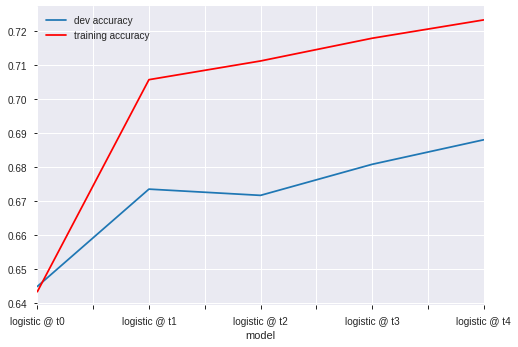

In [604]:
ax = plt.gca()

accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

plt.show()

### Random Forest 

##### Random Forest @ $t_0$

In [605]:
# X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

# parameters_rf = {'n_estimators':[100,100],'max_features':[1,int(np.sqrt(len(dem_var)))]}
# rf = RandomForestClassifier(n_jobs=-1, random_state = random_state)

# t0_rf_accuracy = run_model(model=rf,grid=parameters_rf,label='random forest @ t0')

# accuracy_matrix = pd.DataFrame()
# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

##### Random Forest @ $t_1$

In [606]:
# X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

# parameters_rf = {'n_estimators':[5,5],'max_features':[7,int(np.sqrt(len(var)))]}

# t1_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t1')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

##### Random Forest @ $t_2$

In [607]:
# X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)

# t2_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t2')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

##### Random Forest @ $t_3$

In [608]:
# X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)

# t3_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t3')

# accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_rf_accuracy), sort=False)
# accuracy_matrix.reset_index(inplace=True,drop=True)
# accuracy_matrix

In [609]:
# ax = plt.gca()

# accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
# accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

# plt.show()

### XGBoost

##### XGBoost @ $t_0$

In [610]:
def run_model_xgb(label,num_round):
    
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_dev = xgb.DMatrix(X_dev, label=y_dev)
    
    param = {'max_depth': 6, 'eta': 0.6, 'objective': 'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(d_dev, 'eval'), (d_train, 'train')]

    bst = xgb.train(param, d_train, num_round, evallist, verbose_eval=True)
    
    y_dev_pred = (bst.predict(d_dev) > 0.5) * 1
    y_train_pred = (bst.predict(d_train) > 0.5) * 1
    p_pred = bst.predict(d_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    dev_f1 = f1_score(y_dev,y_dev_pred)
    train_f1 = f1_score(y_train,y_train_pred)
    dev_precision = precision_score(y_dev,y_dev_pred)
    train_precision = precision_score(y_train,y_train_pred)
    dev_recall = recall_score(y_dev,y_dev_pred)
    train_recall = recall_score(y_train,y_train_pred)
    dev_roc = roc_auc_score(y_dev,y_dev_pred)
    train_roc = roc_auc_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n {}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    metrics = {'model':label,
               'dev accuracy':[dev_accuracy], 
               'training accuracy':[train_accuracy],
               'dev f1':[dev_f1],
               'training f1':[train_f1],
               'dev precision':[dev_precision],
               'training precision':[train_precision],
               'dev recall':[dev_recall],
               'training recall':[train_recall],
               'dev roc':[dev_roc],
               'training roc':[train_roc]
              } 
    
    predict = {'predicted dev values':[y_dev_pred],
               'predicted training values':[y_train_pred],
               'predicted probabilities':[p_pred],
               'confusion matrix':[cm],
               'classification report':[report]}
    
    return (metrics, predict)

In [611]:
epochs = 14

In [612]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)
metrics,_ = run_model_xgb('xgb@t0',epochs)

[0]	eval-auc:0.685141	train-auc:0.73819
[1]	eval-auc:0.682577	train-auc:0.761158
[2]	eval-auc:0.682725	train-auc:0.777396
[3]	eval-auc:0.667992	train-auc:0.786691
[4]	eval-auc:0.670305	train-auc:0.792614
[5]	eval-auc:0.671611	train-auc:0.795975
[6]	eval-auc:0.664533	train-auc:0.802977
[7]	eval-auc:0.661306	train-auc:0.81602
[8]	eval-auc:0.659202	train-auc:0.817855
[9]	eval-auc:0.658543	train-auc:0.823794
[10]	eval-auc:0.659334	train-auc:0.828067
[11]	eval-auc:0.660376	train-auc:0.829891
[12]	eval-auc:0.657399	train-auc:0.832826
[13]	eval-auc:0.655704	train-auc:0.841002

accuracy on the dev set is: 0.7266962587190868

accuracy on the train set is: 0.7511100148001973

confusion matrix:

 [[1039  328]
 [ 103  107]]

classification report:

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1367
           1       0.25      0.51      0.33       210

    accuracy                           0.73      1577
   macro avg       0.58      0.63  

In [613]:
acc_mat = accuracy_matrix_fn(pd.DataFrame(), metrics)
acc_mat

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.726696,0.75111,0.331783,0.748943,0.245977,0.755522,0.509524,0.742477,0.634791,0.75111


##### XGBoost @ $t_1$

In [614]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

metrics,_ = run_model_xgb('xgb@t1',epochs)

[0]	eval-auc:0.684045	train-auc:0.870664
[1]	eval-auc:0.714599	train-auc:0.898163
[2]	eval-auc:0.727537	train-auc:0.921224
[3]	eval-auc:0.738269	train-auc:0.936371
[4]	eval-auc:0.740396	train-auc:0.941764
[5]	eval-auc:0.735196	train-auc:0.94438
[6]	eval-auc:0.736428	train-auc:0.9484
[7]	eval-auc:0.736811	train-auc:0.950537
[8]	eval-auc:0.737428	train-auc:0.953872
[9]	eval-auc:0.740137	train-auc:0.955878
[10]	eval-auc:0.739273	train-auc:0.958058
[11]	eval-auc:0.740806	train-auc:0.958679
[12]	eval-auc:0.741936	train-auc:0.95959
[13]	eval-auc:0.741031	train-auc:0.960591

accuracy on the dev set is: 0.8267912772585669

accuracy on the train set is: 0.8942012598933936

confusion matrix:

 [[1266  123]
 [ 155   61]]

classification report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1389
           1       0.33      0.28      0.30       216

    accuracy                           0.83      1605
   macro avg       0.61      0.60    

In [615]:
1-y_dev.mean()

0.8654205607476635

In [616]:
acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.726696,0.751110,0.331783,0.748943,0.245977,0.755522,0.509524,0.742477,0.634791,0.751110
1,xgb@t1,0.826791,0.894201,0.305000,0.887967,0.331522,0.943566,0.282407,0.838556,0.596927,0.894201


##### XGBoost @ $t_2$

In [617]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t2',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

[0]	eval-auc:0.719595	train-auc:0.834908
[1]	eval-auc:0.728983	train-auc:0.904125
[2]	eval-auc:0.730563	train-auc:0.930716
[3]	eval-auc:0.743479	train-auc:0.935099
[4]	eval-auc:0.74731	train-auc:0.939337
[5]	eval-auc:0.746743	train-auc:0.943202
[6]	eval-auc:0.745718	train-auc:0.946227
[7]	eval-auc:0.750812	train-auc:0.948038
[8]	eval-auc:0.744674	train-auc:0.951139
[9]	eval-auc:0.744467	train-auc:0.952964
[10]	eval-auc:0.742079	train-auc:0.955105
[11]	eval-auc:0.740718	train-auc:0.956819
[12]	eval-auc:0.74187	train-auc:0.957951
[13]	eval-auc:0.743517	train-auc:0.958883

accuracy on the dev set is: 0.8412650602409638

accuracy on the train set is: 0.8914550108289033

confusion matrix:

 [[2681  185]
 [ 342  112]]

classification report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2866
           1       0.38      0.25      0.30       454

    accuracy                           0.84      3320
   macro avg       0.63      0.59  

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.726696,0.751110,0.331783,0.748943,0.245977,0.755522,0.509524,0.742477,0.634791,0.751110
1,xgb@t1,0.826791,0.894201,0.305000,0.887967,0.331522,0.943566,0.282407,0.838556,0.596927,0.894201
2,xgb@t2,0.841265,0.891455,0.298269,0.885287,0.377104,0.938625,0.246696,0.837685,0.591073,0.891455


##### XGBoost @ $t_3$

In [618]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t3',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

[0]	eval-auc:0.731678	train-auc:0.834979
[1]	eval-auc:0.742581	train-auc:0.859096
[2]	eval-auc:0.739176	train-auc:0.880346
[3]	eval-auc:0.740099	train-auc:0.895951
[4]	eval-auc:0.734188	train-auc:0.924405
[5]	eval-auc:0.738474	train-auc:0.929467
[6]	eval-auc:0.741056	train-auc:0.93274
[7]	eval-auc:0.73946	train-auc:0.936977
[8]	eval-auc:0.737358	train-auc:0.940034
[9]	eval-auc:0.733136	train-auc:0.945541
[10]	eval-auc:0.734184	train-auc:0.949192
[11]	eval-auc:0.735556	train-auc:0.952673
[12]	eval-auc:0.735615	train-auc:0.954378
[13]	eval-auc:0.737043	train-auc:0.955792

accuracy on the dev set is: 0.8146669468375709

accuracy on the train set is: 0.8874498963372495

confusion matrix:

 [[3700  387]
 [ 495  177]]

classification report:

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4087
           1       0.31      0.26      0.29       672

    accuracy                           0.81      4759
   macro avg       0.60      0.58  

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.726696,0.751110,0.331783,0.748943,0.245977,0.755522,0.509524,0.742477,0.634791,0.751110
1,xgb@t1,0.826791,0.894201,0.305000,0.887967,0.331522,0.943566,0.282407,0.838556,0.596927,0.894201
2,xgb@t2,0.841265,0.891455,0.298269,0.885287,0.377104,0.938625,0.246696,0.837685,0.591073,0.891455
3,xgb@t3,0.814667,0.887450,0.286408,0.882671,0.313830,0.921813,0.263393,0.846717,0.584351,0.887450


##### XGBoost @ $t_4$

In [619]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t4',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

[0]	eval-auc:0.733888	train-auc:0.849453
[1]	eval-auc:0.743338	train-auc:0.871126
[2]	eval-auc:0.739003	train-auc:0.889361
[3]	eval-auc:0.726009	train-auc:0.908608
[4]	eval-auc:0.719098	train-auc:0.915838
[5]	eval-auc:0.726022	train-auc:0.922763
[6]	eval-auc:0.728324	train-auc:0.928698
[7]	eval-auc:0.732912	train-auc:0.932105
[8]	eval-auc:0.737123	train-auc:0.935853
[9]	eval-auc:0.733658	train-auc:0.938558
[10]	eval-auc:0.734758	train-auc:0.941461
[11]	eval-auc:0.737	train-auc:0.946273
[12]	eval-auc:0.736805	train-auc:0.948807
[13]	eval-auc:0.732029	train-auc:0.953224

accuracy on the dev set is: 0.7888977002379064

accuracy on the train set is: 0.8799302359789027

confusion matrix:

 [[4634  754]
 [ 577  340]]

classification report:

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      5388
           1       0.31      0.37      0.34       917

    accuracy                           0.79      6305
   macro avg       0.60      0.62   

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.726696,0.751110,0.331783,0.748943,0.245977,0.755522,0.509524,0.742477,0.634791,0.751110
1,xgb@t1,0.826791,0.894201,0.305000,0.887967,0.331522,0.943566,0.282407,0.838556,0.596927,0.894201
2,xgb@t2,0.841265,0.891455,0.298269,0.885287,0.377104,0.938625,0.246696,0.837685,0.591073,0.891455
3,xgb@t3,0.814667,0.887450,0.286408,0.882671,0.313830,0.921813,0.263393,0.846717,0.584351,0.887450
4,xgb@t4,0.788898,0.879930,0.338140,0.877450,0.310786,0.895955,0.370774,0.859694,0.615417,0.879930


In [620]:
seq['TRAIN2'].keys()

Index(['COHORT', 'EMPLID', 'TERM_CODE', 'SEMESTER_INDEX', 'EOT_ACAD_PLAN_CD',
       'MAJOR_CHANGE_INDICATOR', 'MAJOR_CHANGE_CNT', 'UNITS_TAKEN', 'BCMP',
       'A', 'AU', 'B', 'C', 'CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU',
       'SUMMER', 'CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 'TERM_GPA', 'CUM_GPA',
       'BCMP_TERM_GPA', 'BCMP_CUM_GPA', 'COMPLETION_RATE',
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'T_COMP', 'T_READ',
       'T_MATH', 'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN',
       'CAUCASIAN', 'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN',
       'VISA NON U.S.', 'CONTINUING GENERATION STUDENT',
       'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN', 'DEP_FAM_1',
       'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25',
       'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7',
   

In [621]:
X_train

,MAJOR_CHANGE_CNT,SUMMER,TERM_GPA,BCMP_TERM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,T_COMP,T_READ,T_MATH
0,0.000000,0.000000,3.500000,0.000000,1.000000,1.066667,0.066667,0.000000,3.600000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.608776,0.236425,-1.257106
1,0.000000,0.000000,3.750000,3.000000,1.000000,1.066667,0.066667,0.000000,3.600000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.608776,0.236425,-1.257106
2,1.000000,0.000000,2.692308,2.000000,1.000000,1.000000,0.066667,0.000000,3.600000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.608776,0.236425,-1.257106
3,1.000000,0.000000,3.714286,0.000000,1.000000,0.983333,0.066667,0.000000,3.600000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.608776,0.236425,-1.257106
4,0.000000,0.000000,1.357143,0.000000,1.000000,0.933333,0.000000,0.214286,2.960000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,-0.028232,-0.246236,0.398150
5,0.000000,0.000000,2.500000,3.000000,0.812500,0.900000,0.000000,0.062500,2.960000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,-0.028232,-0.246236,0.398150
6,0.000000,0.000000,1.625000,0.000000,1.000000,0.800000,0.000000,0.083333,3.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,1.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.552312,1.201746,-0.154127
7,0.000000,0.000000,0.000000,0.000000,0.769231,0.733333,0.000000,0.384615,3.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,1.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.552312,1.201746,-0.154127
8,0.000000,0.000000,2.500000,4.000000,0.800000,0.800000,0.000000,0.133333,2.660000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,-0.995805,-1.452889,-0.374723
9,0.000000,0.000000,2.000000,0.000000,1.000000,0.800000,0.000000,0.083333,2.660000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,